In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pickle 
from qiskit import quantum_info
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator, DensityMatrix, partial_trace, SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
basis_gates=['ecr', 'id', 'ry', 'rx', 'x']
#InteractiveShell.ast_node_interactivity = "all"

#define PBC fixed parity circuit, without global gate
#do SWAP
    #exact simulation
    #Aer simulation (with and without noise)
    #real HW?

In [169]:

def Shat(A,T,G): 
    t = np.tanh(T/4 + G/4)
    tt = np.tanh(T/4 - G/4)
    a=1-t*tt;b=1+t*tt;c=t+tt;d=t-tt
    Shatf = np.array([[a,0,0,c],
                      [0,b,d,0],
                      [0,-d,b,0],
                      [-c,0,0,a]],dtype=complex)
    
    Shatg = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]],dtype=complex)
    f = -(1j/4)*A*(2*np.cosh(T/2)+2*np.cosh(G/2))*(1/np.sinh(T/2))*(1/np.cosh(T/2))
    Shat = f*Shatf+Shatg
    Nalpha = 1+2*A**(2)*(np.cosh(T)/np.sinh(T))*(1/np.sinh(T))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**(2)
    Shat = (-1/np.sqrt(Nalpha))*Shat
    return Shat
def ShatOd(A,T,G): 
    t = np.tanh(T/4 + G/4)
    tt = np.tanh(T/4 - G/4)
    a=1-t*tt;b=1+t*tt;c=t+tt;d=t-tt;
    Shatf = np.array([[a,0,0,c],
                      [0,b,-d,0],
                      [0,d,b,0],
                      [-c,0,0,a]],dtype=complex)
    Shatg = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]],dtype=complex)
    f = -(1j/4)*A*(2*np.cosh(T/2)+2*np.cosh(G/2))*(1/np.sinh(T/2))*(1/np.cosh(T/2))
    Shat = f*Shatf+Shatg
    Nalpha = 1+2*A**(2)*(np.cosh(T)/np.sinh(T))*(1/np.sinh(T))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**(2)
    Shat = (-1/np.sqrt(Nalpha))*Shat
    return Shat
def ShatEv(A,T,G): 
    t = np.tanh(T/4 + G/4)
    tt = np.tanh(T/4 - G/4)
    a=1-t*tt;b=1+t*tt;c=t+tt;d=t-tt
    Shatf = np.array([[a,0,0,-c],
                      [0,b,d,0],
                      [0,-d,b,0],
                      [c,0,0,a]],dtype=complex)
    Shatg = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]],dtype=complex)
    f = -(1j/4)*A*(2*np.cosh(T/2)+2*np.cosh(G/2))*(1/np.sinh(T/2))*(1/np.cosh(T/2))
    Shat = f*Shatf+Shatg
    Nalpha = 1+2*A**(2)*(np.cosh(T)/np.sinh(T))*(1/np.sinh(T))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**(2)
    Shat = (-1/np.sqrt(Nalpha))*Shat
    return Shat
def bwassembler_z(qc,matrix,layers,n):    #CHECKED#
    
    m=0
    while m < layers:
        i=0;j=0;    
        #even layer
        while i < n/2:
            qc.unitary(matrix, [2*i,2*i+1])
            i+=1;
        qc.barrier(range(n)) 
        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                if(n==8):
                    qc.unitary(perm8site(matrix),[0,1,2,3,4,5,6,7],label='ZZ')
                elif(n==4):
                    qc.unitary(perm4site(matrix),[0,1,2,3],label='ZZ')
                else:
                    raise(KeyboardInterrupt)
                
            else:
                qc.unitary(matrix, [2*j+1,2*j+2])
            
            j+=1;
        qc.barrier(range(n))
        
        m+=1
    
    return(qc)
def bwassembler_zS(qc,matrix,matrix1,layers,n):    
    
    m=0
    while m < layers:
        i=0;j=0;    
        #even layer
        while i < n/2:
            qc.unitary(matrix, [2*i,2*i+1])
            i+=1;
        qc.barrier(range(n)) 
        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                
                qc.unitary(matrix1,[3,0],label='S41Ev')
                
            else:
                qc.unitary(matrix, [2*j+1,2*j+2])
            
            j+=1;
        qc.barrier(range(n))
        
        m+=1
    
    return(qc)



def perm4site(U):   #CHECKED#
    
    P = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]])
    
    P12 = np.kron(P,np.eye(4))
    P23 = np.kron(np.eye(2),np.kron(P,np.eye(2)))
    P34 = np.kron(np.eye(4),P)
    S34 = np.kron(np.eye(4),U)
    
    return P12@P23@P34@S34@P34@P23@P12
def perm8site(U):   #CHECKED#
    
    P = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]])
    
    P12 = np.kron(P,np.eye(2**6))
    P23 = np.kron(np.eye(2),np.kron(P,np.eye(2**5)))
    P34 = np.kron(np.eye(2**2),np.kron(P,np.eye(2**4)))
    P45 = np.kron(np.eye(2**3),np.kron(P,np.eye(2**3)))
    P56 = np.kron(np.eye(2**4),np.kron(P,np.eye(2**2)))
    P67 = np.kron(np.eye(2**5),np.kron(P,np.eye(2**1)))
    P78 = np.kron(np.eye(2**6),P)
    S78 = np.kron(np.eye(2**6),U)
    
    return P12@P23@P34@P45@P56@P67@P78@S78@P78@P67@P56@P45@P34@P23@P12 
def perm_nsite(U,n):   #CHECKED#
    if n < 2:
        raise ValueError("Number of sites (n) must be at least 2.")
    
    # Constructing a sparse array using ijv format
    # row  = np.array([0, 1, 2, 3])
    # col  = np.array([0, 2, 1, 3])
    # data = np.array([1, 1, 1, -1])
    #P=sparse.coo_array((data, (row, col)), shape=(4, 4)).toarray()

    # Define the permutation matrix P
    P = np.array([[1, 0, 0, 0],
                    [0, 0, 1, 0],
                    [0, 1, 0, 0],
                    [0, 0, 0, -1]])
    perm_list=[]
    # Construct permutation matrices and tensor products
    for i in range(0, n - 1):
        Pi = np.kron(np.eye(2 ** i), np.kron(P, np.eye(2 ** (n - i - 2))))
        perm_list.append(Pi)
        
    # Append U tensor product
    S_last = np.kron(np.eye(2 ** (n - 2)), U)
    perm_list.append(S_last)

    result = np.eye(2**n)
    #print(result, result.shape)
    for perm_matrix in perm_list:
        result = result @ perm_matrix

    perm_list.reverse()

    for perm_matrix in perm_list[1:]:
        result = result @ perm_matrix    
        
    return result
#check supercharges commutation on 4 sites
def x(t):
    return np.exp(t/4)
def y(g):
    return np.exp(g/4)
def Qplus4site(t,g):
    Ql12 = x(t)*y(g)*X(1,4)+(1/(x(t)*y(g)))*Z(1,4)@X(2,4)
    Ql34 = x(t)*y(g)*Z(1,4)@Z(2,4)@X(3,4)+(1/(x(t)*y(g)))*Z(1,4)@Z(2,4)@Z(3,4)@X(4,4)
    return Ql12+Ql34
def Qminus4site(t,g):
    Qr12 = (y(t)/x(g))*Y(1,4)+(x(t)/y(g))*Z(1,4)@Y(2,4)
    Qr34 = (y(t)/x(g))*Z(1,4)@Z(2,4)@Y(3,4)+(x(t)/y(g))*Z(1,4)@Z(2,4)@Z(3,4)@Y(4,4)
    return Qr12+Qr34
#Tensor Paulis on nth site given L sites
def X(n,L):
    X = np.array([[0,1],[1,0]])
    return (np.kron(np.eye(2**(n-1)),np.kron(X,np.eye(2**(L-n)))))
def Y(n,L):
    Y = np.array([[0,-1j],[1j,0]])
    return (np.kron(np.eye(2**(n-1)),np.kron(Y,np.eye(2**(L-n)))))    
def Z(n,L):
    Z = np.array([[1,0],[0,-1]])
    return (np.kron(np.eye(2**(n-1)),np.kron(Z,np.eye(2**(L-n)))))    

with Shatf  [[a,0,0,-c],
            [0,-b,-d,0],
            [0,d,-b,0],
            [c,0,0,a]]
we get same qualitative behaviour but slightly different  (b,c,d)

Shatf = np.array([[a,0,0,-c],
                  [0,-b,d,0],
                  [0,-d,-b,0],
                  [c,0,0,a]],dtype=complex) first layer is the same and then they start diverging (b,c)

                  (b,d) doesnt work 

In [124]:
qc = QuantumCircuit(4)
qc = bwassembler_zS(qc,Shat(1,1,1),ShatEv(1,1,1),1,4)
qc = transpile(qc, basis_gates=basis_gates, optimization_level=3)
qc.count_ops()

OrderedDict([('rz', 56), ('sx', 40), ('ecr', 8), ('barrier', 2)])

In [125]:
qc = QuantumCircuit(4)
qc = bwassembler_z(qc,Shat(1,1,1),1,4)
qc = transpile(qc, basis_gates=basis_gates, optimization_level=3)
qc.count_ops()

OrderedDict([('rz', 446),
             ('sx', 261),
             ('ecr', 103),
             ('x', 33),
             ('barrier', 2)])

In [172]:
A,T,G=1,1,1
t = np.tanh(T/4 + G/4)
tt = np.tanh(T/4 - G/4)
f = -(1j/4)*A*(2*np.cosh(T/2)+2*np.cosh(G/2))*(1/np.sinh(T/2))*(1/np.cosh(T/2))
a=1-t*tt;b=1+t*tt;c=t+tt;d=t-tt


-0.8868188839700739j

In [170]:
qc = QuantumCircuit(4)
qc.unitary(ShatEv(1,1,1),[3,0])
oper1=Operator(qc).data

c=QuantumCircuit(4)
c.unitary(perm4site(Shat(1,1,1)),[0,1,2,3])
oper=Operator(c).data
oper1-oper

array([[ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0. 

In [171]:
print_nonzero_coordinates(oper1-oper)

Coordinates of non-zero elements:
(2, 11)
(3, 10)
(4, 13)
(5, 12)
(10, 3)
(11, 2)
(12, 5)
(13, 4)


Coordinates of non-zero elements supporting even states (for ShatEv having c -> -c as prescribed by Mathematica file):
 
(3, 10)->(4,11) in Mathematica: bbff<->fbfb

(5, 12)->(6,13) in Mathematica: bfbf<->ffbb

In [53]:
def print_nonzero_coordinates(arr):
    # Get the indices of non-zero elements using np.nonzero()
    indices = np.nonzero(arr)
    
    # Zip the row and column indices together
    nonzero_indices = list(zip(indices[0], indices[1]))
    
    # Print the coordinates of non-zero elements
    if len(nonzero_indices) > 0:
        print("Coordinates of non-zero elements:")
        for idx in nonzero_indices:
            
            print(idx)
    else:
        print("No non-zero elements found in the array.")



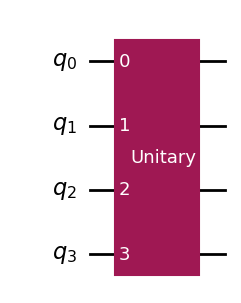

In [526]:
n=4
qu = QuantumCircuit(n)
qu.unitary(perm_nsite(Shat(1,1,1),n),[j for j in range(n)])
#qu = transpile(qu, basis_gates=basis_gates, optimization_level=3)
qu.draw(output='mpl')

In [168]:
A,T,G=1,1,1
qc1 = QuantumCircuit(4)
bwassembler_zS(qc1,Shat(A,T,G),ShatEv(A,T,G),1,4)
qc2 = QuantumCircuit(4)
#bwassembler_zOd(qc2,Shat(A,T,G),1,4)
qc3=QuantumCircuit(4)
bwassembler_z(qc3,Shat(A,T,G),1,4)
#verify commutation with supercharges
Qtot=Qplus4site(1,1)+Qminus4site(1,1)
Qtot2=Qplus4site(1,1)+Qminus4site(1,1)
op1=Operator(qc1).data
op2=Operator(qc2).data
op3=Operator(qc3).data
np.allclose(Qtot@op3-op3@Qtot,np.eye(16)*0)
#qc1.draw(output='mpl')

False

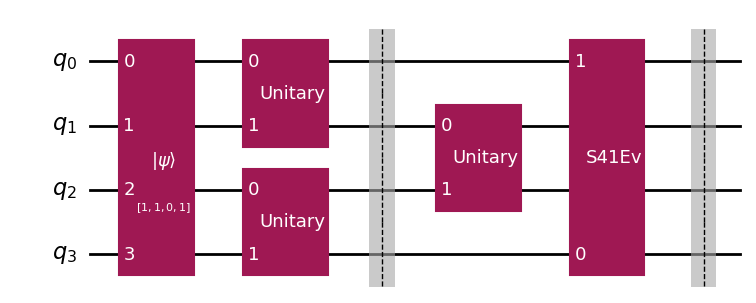

In [460]:
qc = QuantumCircuit(n)
QuantumCircuit.initialize(qc,string)
layer=1
n=4
matrix = Shat(A,theta,G)
matrixev = ShatOd(A,theta,G)
bwassembler_zS(qc,matrix,matrixev,layer,n)

#qc = transpile(qc, basis_gates=basis_gates, optimization_level=3)
qc.draw(output='mpl')
#qc.count_ops()

First we test whether we get same EE spectrum with new matrix given input even parity state |0000>

In [163]:
#BIPARTITION, RE-EE even/odd


#Circuit parameters
n=4;A=0.25;G=0;

#Define arrays
 
thetas= np.arange(1e-10,5,0.05)
layers = [1,2]
sizes = np.array([4])
ent_entropy = np.zeros((len(sizes),len(layers),len(thetas)),dtype=complex)
renyiev = np.zeros((len(sizes),len(layers),len(thetas)),dtype=complex)
#renyi = np.zeros((len(sizes),len(layers),len(thetas)),dtype=complex)
eigvalsrho = np.zeros((len(sizes),len(layers),len(thetas),(2**(n//2))),dtype=complex)
counts = np.zeros((len(layers)))

basis_gates=['ecr', 'id', 'rz', 'x', 'sx']


string = "0000"
for f,n in enumerate(sizes):
    
    subsystem = [j for j in range(0,n//2)]
    print(subsystem)
    
    for m,layer in enumerate(layers):
        
        #print(layer)
        
        for k,theta in enumerate(thetas):    
                
             
            qc = QuantumCircuit(n)
            QuantumCircuit.initialize(qc,string)
            
            #init with Kareljan's state
            #qc.unitary(prodstaten(n), range(0,n))
    
            
            matrix = Shat(A,theta,G)
            matrixev = ShatEv(A,theta,G)
            bwassembler_zS(qc,matrix,matrixev,layer,n)
            #bwassembler_z(qc,matrix,layer,n)
            #qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
            
            
            #######################################################################    
            #access density matrix  
            rho = DensityMatrix(qc)
            
            reduced_rho=partial_trace(rho, subsystem)
            
            #find the eigenvalues of the reduced density matrix
            eigenvalues,_ = np.linalg.eig(reduced_rho)
           
            #compute the entanglement entropy
            
            order = eigenvalues.argsort()
            eigenvalues = eigenvalues[order]
            #eigvalsrho[f,m,k,:]= eigenvalues
            entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
            renyiev[f,m,k]=-np.log(DensityMatrix.purity(reduced_rho))
            #renyi[f,m,k]=-np.log(DensityMatrix.purity(reduced_rho))
            ent_entropy[f,m,k]=entanglement_entropy
            #print(k,ent_entropy[k])
            ######################################################################


[0, 1]


In [164]:
#BIPARTITION, RE-EE normal


#Circuit parameters
#n=4;A=0.25;G=0;

#Define arrays
 
#thetas= np.arange(1e-10,50,0.05)
#layers = [1,2,3,4,5,6]
#sizes = np.array([4])
ent_entropy = np.zeros((len(sizes),len(layers),len(thetas)),dtype=complex)
#renyiev = np.zeros((len(sizes),len(layers),len(thetas)),dtype=complex)
renyi = np.zeros((len(sizes),len(layers),len(thetas)),dtype=complex)
eigvalsrho = np.zeros((len(sizes),len(layers),len(thetas),(2**(n//2))),dtype=complex)
counts = np.zeros((len(layers)))

basis_gates=['ecr', 'id', 'rz', 'x', 'sx']



for f,n in enumerate(sizes):
    
    subsystem = [j for j in range(0,n//2)]
    print(subsystem)
    
    for m,layer in enumerate(layers):
        
        #print(layer)
        
        for k,theta in enumerate(thetas):    
                
            
            qc = QuantumCircuit(n)
            QuantumCircuit.initialize(qc,string)
            
            #init with Kareljan's state
            #qc.unitary(prodstaten(n), range(0,n))
    
            
            matrix = Shat(A,theta,G)
            
            bwassembler_z(qc,matrix,layer,n)
            #qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
            
            
            #######################################################################    
            #access density matrix  
            rho = DensityMatrix(qc)
            
            reduced_rho=partial_trace(rho, subsystem)
            
            #find the eigenvalues of the reduced density matrix
            eigenvalues,_ = np.linalg.eig(reduced_rho)
           
            #compute the entanglement entropy
            
            order = eigenvalues.argsort()
            eigenvalues = eigenvalues[order]
            #eigvalsrho[f,m,k,:]= eigenvalues
            entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
            #renyiev[f,m,k]=-np.log(DensityMatrix.purity(reduced_rho))
            renyi[f,m,k]=-np.log(DensityMatrix.purity(reduced_rho))
            ent_entropy[f,m,k]=entanglement_entropy
            #print(k,ent_entropy[k])
            ######################################################################


[0, 1]


/home/alberto/anaconda3/envs/qusim2/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/alberto/anaconda3/envs/qusim2/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


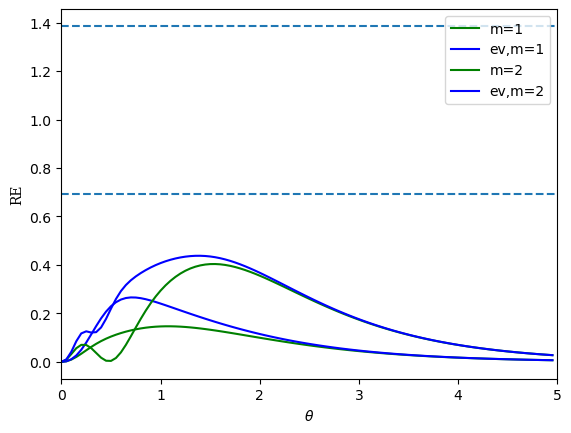

In [165]:


for j,size in enumerate(layers):
    color1 = next(color_cycle1)
    #plt.plot(thetas,ent_entropy[j,0],'-', c=color1,label='EE N='+str(size))
    color2 = next(color_cycle2)
    plt.plot(thetas,renyi[0,j],'-', c='green',label='m='+str(size))
    plt.plot(thetas,renyiev[0,j],'-', c='blue',label='ev,m='+str(size))
    
#plt.plot(thetas,eigvalsrho[0,0,:],'-.')


#plt.title('PBC, A= '+str(A)+' G='+str(G)+' init 0',**csfont)
for j in range(1,3):
    plt.axhline(y=j*np.log(2), linestyle='--')

plt.xlabel(r'$\theta$', **csfont)
plt.ylabel('RE', **csfont)
plt.xlim(0,5)
#plt.ylim(0,1.5)
plt.legend(loc='upper right')   


In [142]:
csfont = {'fontname':'Serif'}
from itertools import cycle
colormap1 = plt.cm.cool
color_cycle1 = cycle(colormap1(np.linspace(0, 1, len(layers))))
colormap2 = plt.cm.spring
color_cycle2 = cycle(colormap2(np.linspace(0, 1, len(sizes))))
leng= np.array([2,3,4],dtype=int)